# Using PowerShell and RegEx to extract text between delimiters

In this post I will share a little PowerShell function that I use quite frequently in order to extract text between delimiters out of a bigger chunk of text. I hope that this can be useful to others too.

One use case for this is when someone forwards an email to me where the original email has lots of recipients. If I want to include some or all of the original recipients I need to extract the email addresses from the original email's message header:

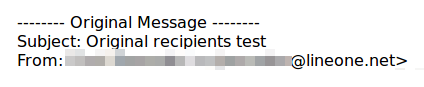

The format of the email addresses in the message header usually follows the pattern NAME <EMAIL@DOMAIN.TLD>, NAME2 <EMAIL2@DOMAIN.TLD ...

The pieces that I'm interested in are delimited by angle brackets. With some RegEx we can extract this information easily:

In [1]:
$testText = 'Peter <peter@gmail.com>, Paul <paul@gmail.com>, Zoe <zoe@gmx.com>'
$pattern = '(?<=\<).+?(?=\>)'
[regex]::Matches($testText, $pattern).Value

The below script needs to be able to find the current output cell; this is an easy method to get it.

peter@gmail.com
paul@gmail.com
zoe@gmx.com


The RegEx can be interpreted like this:

| RegEx | Description |
| --- | --- |
| (?<=\<) | Positive lookbehind. Matches only if the text is preceded by the specificied character ('<' is escaped with '\' to ensure it's taken literally). But does not inlude the character within the match. |
| .+? | Capure one or more (+) of any character ('.'), but only as few characters as possible ('?'). |
| (?=\>) | Positive lookahead. Matches only if the text is followed by the specificied character ('<' is escaped with '\' to ensure it's taken literally). But does not inlude the character within the match. |

In order to make this into more useful I've converted this into a function with the following additional features:
* Specify the enclosing character(s)
   * Specify only the "start" character  (e.g. '[') and having the corresponding "end" character "guessed" (e.g. ']' )
   * Or specify custom start and end characters
* Input text by pipeline

The function can be used like this:

In [27]:
$s=@'
here is /some data\
here is /some other data/
this is /even more data\
'@
Get-TextWithin $s -StartChar / -EndChar \

some data
even more data


In [28]:
$s=@'
here is 'some data'
here is "some other data"
this is 'even more data'
'@
Get-TextWithin $s "'"

some data
even more data


The [Get-TextWitihin](https://github.com/DBremen/PowerShellScripts/blob/master/Data%20Wrangling/Get-TextWithin.ps1) function can also be downloaded via GitHub and is also part of my [PowerShell Scripts](https://github.com/DBremen/PowerShellScripts) collection module.

In [29]:
function Get-TextWithin {
    <#    
        .SYNOPSIS
            Get the text between two surrounding characters (e.g. brackets, quotes, or custom characters)
        .DESCRIPTION
            Use RegEx to retrieve the text within enclosing characters.
	    .PARAMETER Text
            The text to retrieve the matches from.
        .PARAMETER WithinChar
            Single character, indicating the surrounding characters to retrieve the enclosing text for. 
            If this paramater is used the matching ending character is "guessed" (e.g. '(' = ')')
        .PARAMETER StartChar
            Single character, indicating the start surrounding characters to retrieve the enclosing text for. 
        .PARAMETER EndChar
            Single character, indicating the end surrounding characters to retrieve the enclosing text for. 
        .EXAMPLE
            # Retrieve all text within single quotes
		    $s=@'
here is 'some data'
here is "some other data"
this is 'even more data'
'@
             Get-TextWithin $s "'"
    .EXAMPLE
    # Retrieve all text within custom start and end characters
    $s=@'
here is /some data\
here is /some other data/
this is /even more data\
'@
    Get-TextWithin $s -StartChar / -EndChar \
#>
    [CmdletBinding()]
    param( 
        [Parameter(Mandatory, 
            ValueFromPipeline = $true,
            Position = 0)]   
        $Text,
        [Parameter(ParameterSetName = 'Single', Position = 1)] 
        [char]$WithinChar = '"',
        [Parameter(ParameterSetName = 'Double')] 
        [char]$StartChar,
        [Parameter(ParameterSetName = 'Double')] 
        [char]$EndChar
    )
    $htPairs = @{
        '(' = ')'
        '[' = ']'
        '{' = '}'
        '<' = '>'
    }
    if ($PSBoundParameters.ContainsKey('WithinChar')) {
        $StartChar = $EndChar = $WithinChar
        if ($htPairs.ContainsKey([string]$WithinChar)) {
            $EndChar = $htPairs[[string]$WithinChar]
        }
    }
    $pattern = @"
(?<=\$StartChar).+?(?=\$EndChar)
"@
    [regex]::Matches($Text, $pattern).Value
}